<a href=https://keras.io/examples/vision/conv_lstm/>LSTM</a><br>
<a href=https://stanford.edu/%7Eshervine/blog/keras-how-to-generate-data-on-the-fly>Dataset Class</a>

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
from data import DataGenerator
import matplotlib as plt
import os

2023-08-04 15:42:06.812262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


FileNotFoundError: config file doesn't exist: /Users/marcchiu/anaconda3/envs/lamprogen_decon_stardist/lamprogen-python/notebooks/LSTM/models/lamprogen-stardist-trained/config.json

## Define Dataset

In [2]:
import tifffile as tiff
image = tiff.imread("data/masks/230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif")
image.shape

(70, 256, 256)

In [3]:
def get_ids(path='data'):
    images = []
    masks = []
    for file in os.listdir(path+'/images'):
        images.append(file)

    for file in os.listdir(path+'/masks'):
        masks.append(file)

    return images, masks

images, masks = get_ids()
images.sort()
masks.sort()
images = images[:5]
masks = images[:5]

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1)

In [4]:
print(X_train[3])
print(y_train[3])
print(X_test[0])
print(y_test[0])

230413 GLA HEX grad post v2_Plate_1081_well_D03_channel2_0.tif
230413 GLA HEX grad post v2_Plate_1081_well_D03_channel2_0.tif
230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif
230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif


In [36]:
params = {'dim': (70,256,256),
          'batch_size': 5,
          'n_channels': 1,
          'shuffle': True}


training_generator = DataGenerator(X_train, y_train, **params)
validation_generator = DataGenerator(X_test, y_test, **params)

In [29]:

print(training_generator[1][0][0].shape)

(70, 256, 256, 1)


Displaying frames for example 0.


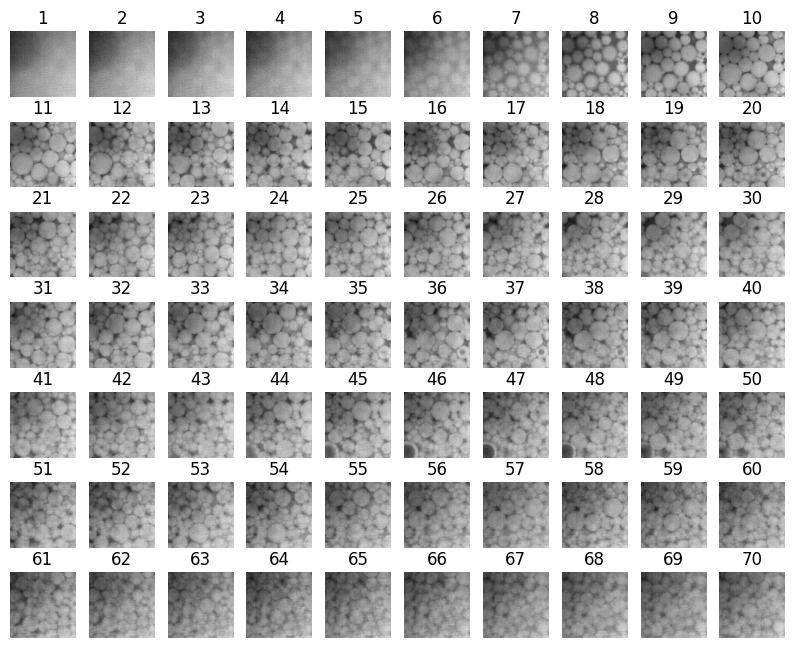

In [33]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(7, 10, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(training_generator[0][0][0][idx]), cmap="gray")
    ax.set_title(f"{idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Define Model

In [40]:
#Load Packages
import keras
from keras import layers

# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(70,256,256,1))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


## Define Traing Loop

In [42]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    generator = training_generator,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20


ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.